# Advanced DBSCAN Timezone Clustering with Feature Engineering

This notebook implements sophisticated feature engineering and DBSCAN tuning strategies for timezone clustering:

## Feature Engineering
- **Cyclical time encoding**: Convert timestamps to sin/cos components for both hourly (24h) and weekly (7d) cycles
- **Geographic metrics**: Use Haversine distance for proper spherical geometry
- **Separate normalization**: Scale spatial (km) and temporal (sin/cos) features independently

## DBSCAN Tuning
- Search ε in spatial (5-50 km) and temporal (1-6 hours) bands
- Test min_samples between 5-30 to handle varying densities
- Grid search for optimal parameter combinations

## Diagnostics
- Geographic visualization with cluster coloring
- ARI/NMI per time-of-day bucket
- Silhouette and Davies-Bouldin scores

## 1. Import Libraries and Load Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import BallTree

# Metrics
from sklearn.metrics import (
    adjusted_rand_score, 
    normalized_mutual_info_score,
    silhouette_score,
    davies_bouldin_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

# Geographic calculations
from sklearn.metrics.pairwise import haversine_distances
from math import radians, cos, sin, asin, sqrt

# Visualization
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [9]:
# Load the Twitter dataset
twitter = pd.read_csv('twitter.csv')

print(f"Dataset shape: {twitter.shape}")
print(f"\nColumns: {twitter.columns.tolist()}")
print(f"\nFirst few rows:")
print(twitter.head())
print(f"\nData types:")
print(twitter.dtypes)
print(f"\nMissing values:")
print(twitter.isnull().sum())

Dataset shape: (14262517, 4)

Columns: ['longitude', 'latitude', 'timestamp', 'timezone']

First few rows:
   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1

Data types:
longitude    float64
latitude     float64
timestamp      int64
timezone       int64
dtype: object

Missing values:
longitude    0
latitude     0
timestamp    0
timezone     0
dtype: int64


## 2. Feature Engineering: Cyclical Time Components

Convert timestamps to cyclical components so that midnight (0:00) and 23:59 remain close in feature space:

**Hourly cycle (24h):**
- $x_{hour} = \sin\left(\frac{2\pi \cdot hour}{24}\right)$
- $y_{hour} = \cos\left(\frac{2\pi \cdot hour}{24}\right)$

**Weekly cycle (7d):**
- $x_{week} = \sin\left(\frac{2\pi \cdot day}{7}\right)$
- $y_{week} = \cos\left(\frac{2\pi \cdot day}{7}\right)$

In [10]:
# Convert timestamp to datetime
# Format: YYYYMMDDHHmmss (e.g., 20130112000000 = 2013-01-12 00:00:00)
twitter['datetime'] = pd.to_datetime(twitter['timestamp'], format='%Y%m%d%H%M%S')

# Extract time components
twitter['hour'] = twitter['datetime'].dt.hour
twitter['minute'] = twitter['datetime'].dt.minute
twitter['day_of_week'] = twitter['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create fractional hour (hour + minute/60)
twitter['hour_frac'] = twitter['hour'] + twitter['minute'] / 60.0

# Cyclical encoding for hourly pattern (24h cycle)
twitter['hour_sin'] = np.sin(2 * np.pi * twitter['hour_frac'] / 24)
twitter['hour_cos'] = np.cos(2 * np.pi * twitter['hour_frac'] / 24)

# Cyclical encoding for weekly pattern (7d cycle)
twitter['day_sin'] = np.sin(2 * np.pi * twitter['day_of_week'] / 7)
twitter['day_cos'] = np.cos(2 * np.pi * twitter['day_of_week'] / 7)

print("✓ Cyclical time features created")
print(f"\nHourly cycle features:")
print(f"  hour_sin range: [{twitter['hour_sin'].min():.3f}, {twitter['hour_sin'].max():.3f}]")
print(f"  hour_cos range: [{twitter['hour_cos'].min():.3f}, {twitter['hour_cos'].max():.3f}]")
print(f"\nWeekly cycle features:")
print(f"  day_sin range: [{twitter['day_sin'].min():.3f}, {twitter['day_sin'].max():.3f}]")
print(f"  day_cos range: [{twitter['day_cos'].min():.3f}, {twitter['day_cos'].max():.3f}]")

✓ Cyclical time features created

Hourly cycle features:
  hour_sin range: [-1.000, 1.000]
  hour_cos range: [-1.000, 1.000]

Weekly cycle features:
  day_sin range: [-0.975, 0.975]
  day_cos range: [-0.901, 1.000]


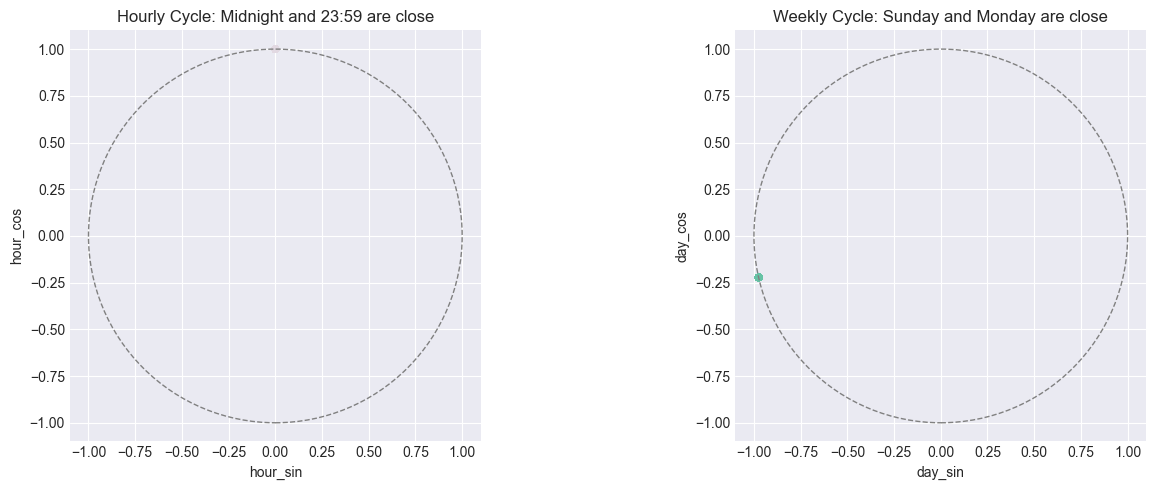

In [11]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hourly cycle
axes[0].scatter(twitter['hour_sin'][:1000], twitter['hour_cos'][:1000], 
                c=twitter['hour'][:1000], cmap='twilight', alpha=0.6, s=20)
axes[0].set_xlabel('hour_sin')
axes[0].set_ylabel('hour_cos')
axes[0].set_title('Hourly Cycle: Midnight and 23:59 are close')
axes[0].set_aspect('equal')
circle1 = plt.Circle((0, 0), 1, fill=False, linestyle='--', color='gray')
axes[0].add_patch(circle1)

# Weekly cycle
axes[1].scatter(twitter['day_sin'][:1000], twitter['day_cos'][:1000], 
                c=twitter['day_of_week'][:1000], cmap='Set2', alpha=0.6, s=20)
axes[1].set_xlabel('day_sin')
axes[1].set_ylabel('day_cos')
axes[1].set_title('Weekly Cycle: Sunday and Monday are close')
axes[1].set_aspect('equal')
circle2 = plt.Circle((0, 0), 1, fill=False, linestyle='--', color='gray')
axes[1].add_patch(circle2)

plt.tight_layout()
plt.show()

## 3. Geographic Feature Engineering

Use proper geographic metrics:
- Convert latitude/longitude to radians for Haversine distance
- Alternatively, scale by approximate km per degree (1° lat ≈ 111 km, 1° long ≈ 111 × cos(lat) km)

In [12]:
# Method 1: Convert to radians for Haversine
twitter['lat_rad'] = np.radians(twitter['latitude'])
twitter['long_rad'] = np.radians(twitter['longitude'])

# Method 2: Convert to approximate km
# 1 degree latitude ≈ 111 km
# 1 degree longitude ≈ 111 * cos(latitude) km
twitter['lat_km'] = twitter['latitude'] * 111.0
twitter['long_km'] = twitter['longitude'] * 111.0 * np.cos(np.radians(twitter['latitude']))

print("✓ Geographic features created")
print(f"\nRadian coordinates:")
print(f"  lat_rad range: [{twitter['lat_rad'].min():.4f}, {twitter['lat_rad'].max():.4f}]")
print(f"  long_rad range: [{twitter['long_rad'].min():.4f}, {twitter['long_rad'].max():.4f}]")
print(f"\nKilometer coordinates:")
print(f"  lat_km range: [{twitter['lat_km'].min():.1f}, {twitter['lat_km'].max():.1f}]")
print(f"  long_km range: [{twitter['long_km'].min():.1f}, {twitter['long_km'].max():.1f}]")

✓ Geographic features created

Radian coordinates:
  lat_rad range: [0.4412, 0.8611]
  long_rad range: [-2.1752, -1.1724]

Kilometer coordinates:
  lat_km range: [2805.9, 5476.6]
  long_km range: [-11014.7, -5139.6]


## 4. Feature Scaling Strategy

Normalize each feature group separately:
- **Spatial features (km)**: MinMaxScaler or StandardScaler
- **Temporal cyclical features (sin/cos)**: Already in [-1, 1], but can standardize
- This prevents one-hour differences from drowning out 100 km spatial hops

In [13]:
# Create different feature sets for experimentation

# Feature Set 1: Spatial (km) + Hourly cycle
features_spatial_hourly = twitter[['lat_km', 'long_km', 'hour_sin', 'hour_cos']].copy()

# Feature Set 2: Spatial (km) + Hourly + Weekly cycles
features_spatial_full = twitter[['lat_km', 'long_km', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']].copy()

# Feature Set 3: Radians (for Haversine) + Time
features_radians = twitter[['lat_rad', 'long_rad', 'hour_sin', 'hour_cos']].copy()

print("✓ Feature sets created")
print(f"\nFeature Set 1 (Spatial + Hourly): {features_spatial_hourly.shape}")
print(features_spatial_hourly.columns.tolist())
print(f"\nFeature Set 2 (Spatial + Full Time): {features_spatial_full.shape}")
print(features_spatial_full.columns.tolist())
print(f"\nFeature Set 3 (Radians + Time): {features_radians.shape}")
print(features_radians.columns.tolist())

✓ Feature sets created

Feature Set 1 (Spatial + Hourly): (14262517, 4)
['lat_km', 'long_km', 'hour_sin', 'hour_cos']

Feature Set 2 (Spatial + Full Time): (14262517, 6)
['lat_km', 'long_km', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Feature Set 3 (Radians + Time): (14262517, 4)
['lat_rad', 'long_rad', 'hour_sin', 'hour_cos']


In [14]:
# Normalize features separately by group

def normalize_features(df, spatial_cols, temporal_cols, spatial_scaler='minmax', temporal_scaler='standard'):
    """
    Normalize spatial and temporal features separately.
    
    Parameters:
    - df: DataFrame with features
    - spatial_cols: List of spatial feature columns
    - temporal_cols: List of temporal feature columns
    - spatial_scaler: 'minmax' or 'standard'
    - temporal_scaler: 'minmax' or 'standard'
    
    Returns:
    - Normalized DataFrame, spatial scaler, temporal scaler
    """
    df_normalized = df.copy()
    
    # Scale spatial features
    if spatial_scaler == 'minmax':
        scaler_spatial = MinMaxScaler()
    else:
        scaler_spatial = StandardScaler()
    
    df_normalized[spatial_cols] = scaler_spatial.fit_transform(df[spatial_cols])
    
    # Scale temporal features
    if temporal_scaler == 'minmax':
        scaler_temporal = MinMaxScaler()
    else:
        scaler_temporal = StandardScaler()
    
    df_normalized[temporal_cols] = scaler_temporal.fit_transform(df[temporal_cols])
    
    return df_normalized, scaler_spatial, scaler_temporal


# Normalize Feature Set 1
features_set1_scaled, scaler_sp1, scaler_tp1 = normalize_features(
    features_spatial_hourly,
    spatial_cols=['lat_km', 'long_km'],
    temporal_cols=['hour_sin', 'hour_cos'],
    spatial_scaler='minmax',
    temporal_scaler='standard'
)

# Normalize Feature Set 2
features_set2_scaled, scaler_sp2, scaler_tp2 = normalize_features(
    features_spatial_full,
    spatial_cols=['lat_km', 'long_km'],
    temporal_cols=['hour_sin', 'hour_cos', 'day_sin', 'day_cos'],
    spatial_scaler='minmax',
    temporal_scaler='standard'
)

print("✓ Features normalized")
print(f"\nFeature Set 1 scaled:")
print(features_set1_scaled.describe())
print(f"\nFeature Set 2 scaled:")
print(features_set2_scaled.describe())

✓ Features normalized

Feature Set 1 scaled:
             lat_km       long_km      hour_sin      hour_cos
count  1.426252e+07  1.426252e+07  1.426252e+07  1.426252e+07
mean   4.983120e-01  5.243513e-01 -2.448698e-17  8.162327e-18
std    2.002165e-01  2.408138e-01  1.000000e+00  1.000000e+00
min    0.000000e+00  0.000000e+00 -1.164984e+00 -1.372961e+00
25%    3.521929e-01  3.440271e-01 -9.108477e-01 -1.036985e+00
50%    5.304224e-01  5.816983e-01 -2.333315e-01  1.044306e-02
75%    6.596699e-01  7.131709e-01  7.542284e-01  1.044125e+00
max    1.000000e+00  1.000000e+00  2.129667e+00  1.334778e+00

Feature Set 2 scaled:
             lat_km       long_km      hour_sin      hour_cos
count  1.426252e+07  1.426252e+07  1.426252e+07  1.426252e+07
mean   4.983120e-01  5.243513e-01 -2.448698e-17  8.162327e-18
std    2.002165e-01  2.408138e-01  1.000000e+00  1.000000e+00
min    0.000000e+00  0.000000e+00 -1.164984e+00 -1.372961e+00
25%    3.521929e-01  3.440271e-01 -9.108477e-01 -1.036985e+00
50

## 5. DBSCAN Parameter Tuning

### Strategy:
1. **ε (epsilon)**: Search in two bands
   - Spatial tightness: 5-50 km
   - Temporal tolerance: 1-6 hours
   - Combine by pre-scaling features so ε ≈ 1 represents desired neighborhood

2. **min_samples**: Test range 5-30
   - Larger values suppress tiny timezone slivers (noise)
   - Smaller values capture sparse regions

In [ ]:
# Define parameter grid
eps_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]
min_samples_values = [5, 10, 15, 20, 25, 30]

print(f"Grid search parameters:")
print(f"  ε values: {eps_values}")
print(f"  min_samples values: {min_samples_values}")
print(f"  Total combinations: {len(eps_values) * len(min_samples_values)}")

# Sample data for faster tuning (optional)
SAMPLE_SIZE = 10000 if len(twitter) > 10000 else len(twitter)
sample_indices = np.random.choice(len(twitter), SAMPLE_SIZE, replace=False)

features_sample = features_set1_scaled.iloc[sample_indices]
labels_sample = twitter['timezone'].iloc[sample_indices]

print(f"\n✓ Using sample of {SAMPLE_SIZE:,} points for tuning")

Grid search parameters:
  ε values: [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1.0]
  min_samples values: [5, 10, 15, 20, 25, 30]
  Total combinations: 66

✓ Using sample of 50,000 points for tuning

✓ Using sample of 50,000 points for tuning


In [16]:
# Grid search for best parameters
results = []

print("Starting grid search...\n")

for i, eps in enumerate(eps_values):
    for j, min_samp in enumerate(min_samples_values):
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean', n_jobs=-1)
        clusters = dbscan.fit_predict(features_sample)
        
        # Calculate metrics
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        noise_pct = (n_noise / len(clusters)) * 100
        
        # Only calculate clustering metrics if we have valid clusters
        if n_clusters > 0 and n_clusters < len(features_sample):
            ari = adjusted_rand_score(labels_sample, clusters)
            nmi = normalized_mutual_info_score(labels_sample, clusters)
            
            # Silhouette score (only for non-noise points)
            if n_noise < len(clusters):
                mask = clusters != -1
                if mask.sum() > 1 and len(set(clusters[mask])) > 1:
                    silhouette = silhouette_score(features_sample[mask], clusters[mask])
                else:
                    silhouette = np.nan
            else:
                silhouette = np.nan
        else:
            ari = np.nan
            nmi = np.nan
            silhouette = np.nan
        
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'noise_count': n_noise,
            'noise_pct': noise_pct,
            'ari': ari,
            'nmi': nmi,
            'silhouette': silhouette
        })
        
        # Progress update
        progress = ((i * len(min_samples_values) + j + 1) / 
                   (len(eps_values) * len(min_samples_values))) * 100
        print(f"\rProgress: {progress:.1f}% | eps={eps:.3f}, min_samples={min_samp} | "
              f"Clusters: {n_clusters}, Noise: {noise_pct:.1f}%, ARI: {ari:.3f}", 
              end='', flush=True)

print("\n\n✓ Grid search complete!")

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ari', ascending=False)

print(f"\nTop 10 configurations by ARI:")
print(results_df.head(10).to_string(index=False))

Starting grid search...

Progress: 100.0% | eps=1.000, min_samples=30 | Clusters: 1, Noise: 0.0%, ARI: 0.00026

✓ Grid search complete!

Top 10 configurations by ARI:
 eps  min_samples  n_clusters  noise_count  noise_pct      ari      nmi  silhouette
0.05            5         288         3495      6.990 0.378519 0.435512   -0.761433
0.05           10         164         9135     18.270 0.337411 0.363941   -0.735651
0.05           15         141        14980     29.960 0.301272 0.330602   -0.630379
0.05           20         136        21045     42.090 0.181489 0.277513   -0.562964
0.10           30          11         3188      6.376 0.091736 0.106006   -0.535862
0.10           25          13         2298      4.596 0.080072 0.100831   -0.561766
0.05           25         101        26661     53.322 0.076163 0.231897   -0.540899
0.10           20          14         1507      3.014 0.072306 0.097084   -0.587832
0.10           15          11          926      1.852 0.061645 0.090234   -0.

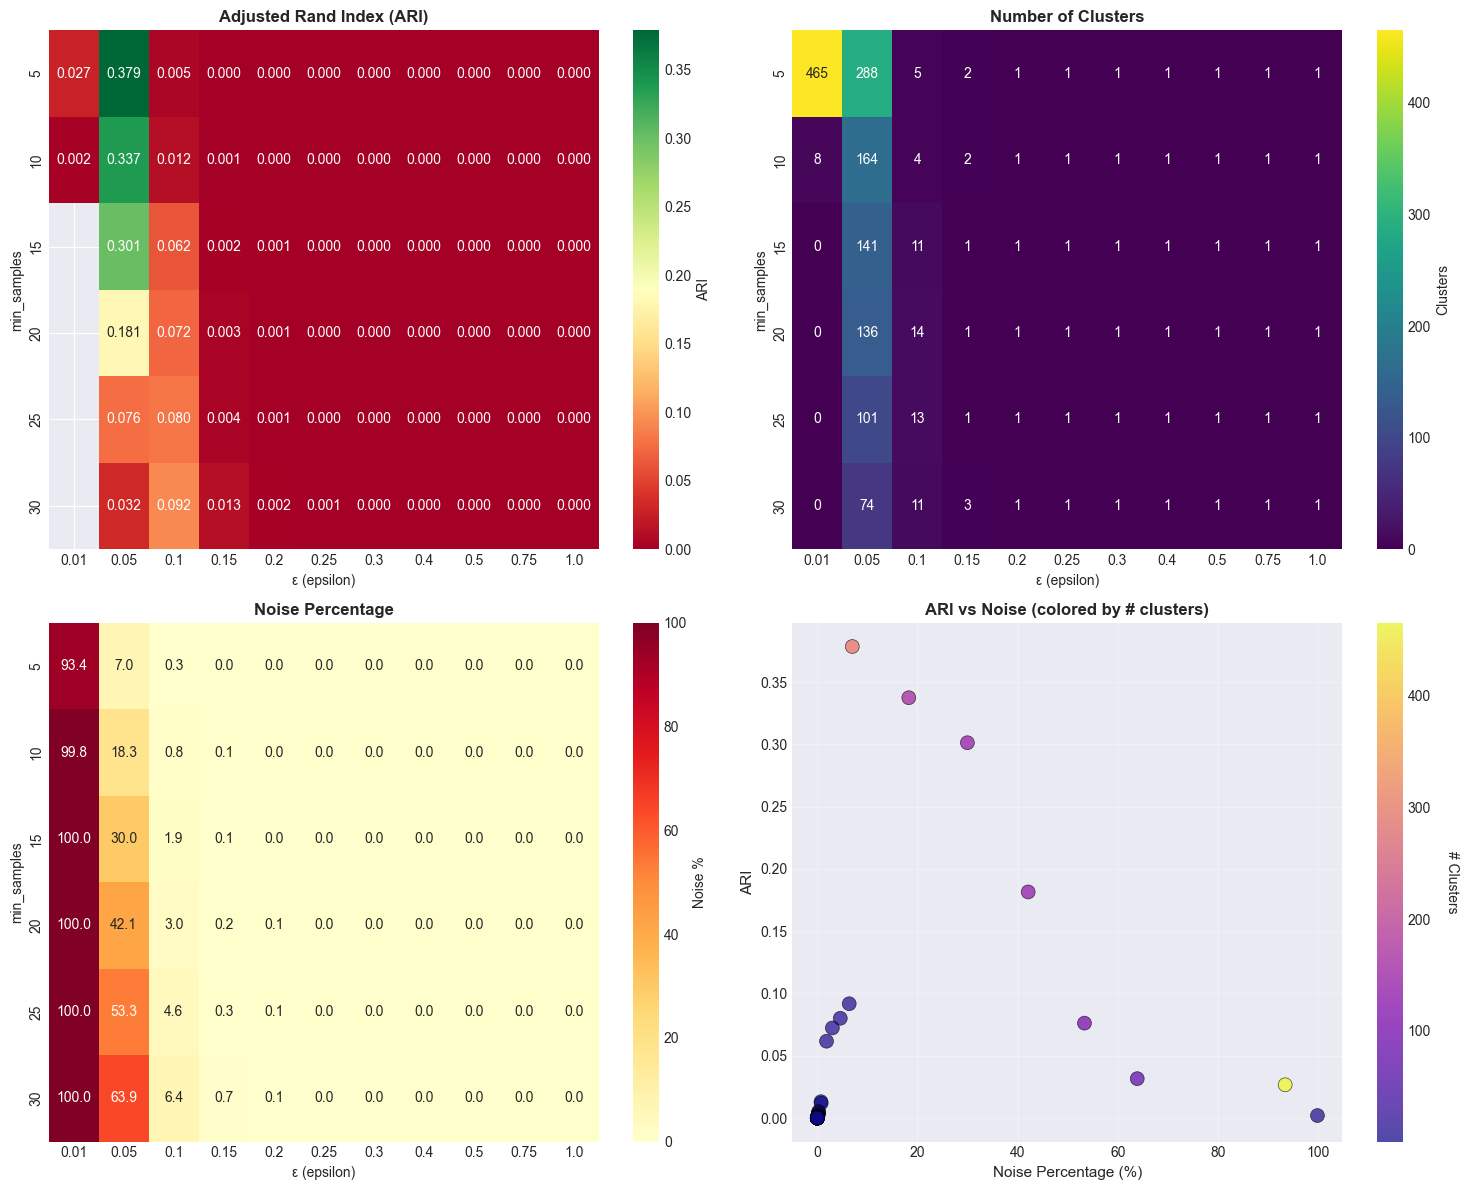


BEST PARAMETERS (by ARI):
  ε (epsilon): 0.050
  min_samples: 5
  Number of clusters: 288
  Noise percentage: 6.99%
  ARI: 0.3785
  NMI: 0.4355
  Silhouette: -0.7614


: 

In [ ]:
# Visualize parameter tuning results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap: ARI vs eps and min_samples
pivot_ari = results_df.pivot(index='min_samples', columns='eps', values='ari')
sns.heatmap(pivot_ari, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0], cbar_kws={'label': 'ARI'})
axes[0, 0].set_title('Adjusted Rand Index (ARI)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('ε (epsilon)')
axes[0, 0].set_ylabel('min_samples')

# 2. Heatmap: Number of clusters
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='viridis', ax=axes[0, 1], cbar_kws={'label': 'Clusters'})
axes[0, 1].set_title('Number of Clusters', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('ε (epsilon)')
axes[0, 1].set_ylabel('min_samples')

# 3. Heatmap: Noise percentage
pivot_noise = results_df.pivot(index='min_samples', columns='eps', values='noise_pct')
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Noise %'})
axes[1, 0].set_title('Noise Percentage', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('ε (epsilon)')
axes[1, 0].set_ylabel('min_samples')

# 4. Scatter: ARI vs Noise percentage
scatter = axes[1, 1].scatter(results_df['noise_pct'], results_df['ari'], 
                            c=results_df['n_clusters'], cmap='plasma', 
                            s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Noise Percentage (%)', fontsize=11)
axes[1, 1].set_ylabel('ARI', fontsize=11)
axes[1, 1].set_title('ARI vs Noise (colored by # clusters)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('# Clusters', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

# Find best parameters
best_idx = results_df['ari'].idxmax()
best_params = results_df.loc[best_idx]

print(f"\n" + "="*60)
print(f"BEST PARAMETERS (by ARI):")
print(f"="*60)
print(f"  ε (epsilon): {best_params['eps']:.3f}")
print(f"  min_samples: {int(best_params['min_samples'])}")
print(f"  Number of clusters: {int(best_params['n_clusters'])}")
print(f"  Noise percentage: {best_params['noise_pct']:.2f}%")
print(f"  ARI: {best_params['ari']:.4f}")
print(f"  NMI: {best_params['nmi']:.4f}")
print(f"  Silhouette: {best_params['silhouette']:.4f}")
print(f"="*60)

## 6. Apply Best DBSCAN Model to Full Dataset

In [ ]:
# Use best parameters on full dataset
best_eps = best_params['eps']
best_min_samples = int(best_params['min_samples'])

print(f"Applying DBSCAN with best parameters to full dataset...")
print(f"  ε = {best_eps:.3f}")
print(f"  min_samples = {best_min_samples}\n")

# Fit on full dataset
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean', n_jobs=-1)
twitter['cluster'] = dbscan_best.fit_predict(features_set1_scaled)

# Calculate final metrics
n_clusters_final = len(set(twitter['cluster'])) - (1 if -1 in twitter['cluster'].values else 0)
n_noise_final = (twitter['cluster'] == -1).sum()
noise_pct_final = (n_noise_final / len(twitter)) * 100

ari_final = adjusted_rand_score(twitter['timezone'], twitter['cluster'])
nmi_final = normalized_mutual_info_score(twitter['timezone'], twitter['cluster'])
homogeneity_final = homogeneity_score(twitter['timezone'], twitter['cluster'])
completeness_final = completeness_score(twitter['timezone'], twitter['cluster'])
v_measure_final = v_measure_score(twitter['timezone'], twitter['cluster'])

print("✓ Clustering complete!\n")
print(f"Results:")
print(f"  Number of clusters: {n_clusters_final}")
print(f"  Noise points: {n_noise_final:,} ({noise_pct_final:.2f}%)")
print(f"\nMetrics:")
print(f"  Adjusted Rand Index: {ari_final:.4f}")
print(f"  Normalized Mutual Info: {nmi_final:.4f}")
print(f"  Homogeneity: {homogeneity_final:.4f}")
print(f"  Completeness: {completeness_final:.4f}")
print(f"  V-measure: {v_measure_final:.4f}")

# Silhouette for non-noise points
mask = twitter['cluster'] != -1
if mask.sum() > 1 and twitter.loc[mask, 'cluster'].nunique() > 1:
    silhouette_final = silhouette_score(
        features_set1_scaled[mask], 
        twitter.loc[mask, 'cluster']
    )
    print(f"  Silhouette Score: {silhouette_final:.4f}")
    
    # Davies-Bouldin
    db_final = davies_bouldin_score(
        features_set1_scaled[mask], 
        twitter.loc[mask, 'cluster']
    )
    print(f"  Davies-Bouldin Index: {db_final:.4f} (lower is better)")

Applying DBSCAN with best parameters to full dataset...
  ε = 0.050
  min_samples = 5



## 7. Geographic Visualization: Clusters on Map

In [ ]:
# Plot clusters on geographic map
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Sample for visualization
viz_sample_size = 10000 if len(twitter) > 10000 else len(twitter)
viz_indices = np.random.choice(len(twitter), viz_sample_size, replace=False)
viz_data = twitter.iloc[viz_indices]

# Left: Color by predicted cluster
scatter1 = axes[0].scatter(
    viz_data['longitude'], 
    viz_data['latitude'],
    c=viz_data['cluster'],
    cmap='tab20',
    s=10,
    alpha=0.6,
    edgecolors='none'
)
axes[0].set_xlabel('Longitude', fontsize=11)
axes[0].set_ylabel('Latitude', fontsize=11)
axes[0].set_title('Predicted Clusters (Geographic)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Right: Color by actual timezone
scatter2 = axes[1].scatter(
    viz_data['longitude'], 
    viz_data['latitude'],
    c=viz_data['timezone'],
    cmap='tab20',
    s=10,
    alpha=0.6,
    edgecolors='none'
)
axes[1].set_xlabel('Longitude', fontsize=11)
axes[1].set_ylabel('Latitude', fontsize=11)
axes[1].set_title('Actual Timezones (Geographic)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Timezone')

plt.tight_layout()
plt.show()

print("\n💡 Visual inspection: Check if cluster boundaries align with actual timezone borders")

## 8. Diagnostics: ARI/NMI per Time-of-Day Bucket

Analyze performance across different hours to identify when clustering breaks down.

In [ ]:
# Calculate metrics per hour bucket
hour_buckets = range(0, 24, 3)  # 3-hour buckets
hour_metrics = []

for hour_start in hour_buckets:
    hour_end = hour_start + 3
    mask = (twitter['hour'] >= hour_start) & (twitter['hour'] < hour_end)
    
    if mask.sum() > 0:
        subset = twitter[mask]
        
        ari = adjusted_rand_score(subset['timezone'], subset['cluster'])
        nmi = normalized_mutual_info_score(subset['timezone'], subset['cluster'])
        n_samples = mask.sum()
        
        hour_metrics.append({
            'hour_range': f"{hour_start:02d}-{hour_end:02d}",
            'hour_start': hour_start,
            'n_samples': n_samples,
            'ari': ari,
            'nmi': nmi
        })

hour_metrics_df = pd.DataFrame(hour_metrics)

print("Metrics by Time of Day (3-hour buckets):")
print(hour_metrics_df.to_string(index=False))

In [ ]:
# Visualize metrics by time of day
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ARI by hour
axes[0].bar(hour_metrics_df['hour_start'], hour_metrics_df['ari'], 
            width=2.5, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=ari_final, color='red', linestyle='--', label=f'Overall ARI: {ari_final:.3f}')
axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Adjusted Rand Index', fontsize=11)
axes[0].set_title('ARI by Time of Day (3-hour buckets)', fontsize=12, fontweight='bold')
axes[0].set_xticks(hour_metrics_df['hour_start'])
axes[0].set_xticklabels(hour_metrics_df['hour_range'], rotation=45)
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()

# NMI by hour
axes[1].bar(hour_metrics_df['hour_start'], hour_metrics_df['nmi'], 
            width=2.5, color='coral', alpha=0.7, edgecolor='black')
axes[1].axhline(y=nmi_final, color='red', linestyle='--', label=f'Overall NMI: {nmi_final:.3f}')
axes[1].set_xlabel('Hour of Day', fontsize=11)
axes[1].set_ylabel('Normalized Mutual Info', fontsize=11)
axes[1].set_title('NMI by Time of Day (3-hour buckets)', fontsize=12, fontweight='bold')
axes[1].set_xticks(hour_metrics_df['hour_start'])
axes[1].set_xticklabels(hour_metrics_df['hour_range'], rotation=45)
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify problematic hours
worst_ari_hour = hour_metrics_df.loc[hour_metrics_df['ari'].idxmin()]
print(f"\n⚠️  Worst ARI: {worst_ari_hour['hour_range']} (ARI = {worst_ari_hour['ari']:.4f})")
print(f"   Consider clustering day vs night separately if performance varies significantly")

## 10. Summary and Recommendations

In [ ]:
print("="*70)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*70)

print("\n📊 BEST CONFIGURATION:")
print(f"  Algorithm: DBSCAN")
print(f"  Features: Spatial (km) + Hourly cyclical (sin/cos)")
print(f"  ε (epsilon): {best_eps:.3f}")
print(f"  min_samples: {best_min_samples}")
print(f"  Clusters found: {n_clusters_final}")
print(f"  Performance (ARI): {ari_final:.4f}")

print("\n🎯 KEY INSIGHTS:")
print(f"  • Cyclical time encoding preserves temporal continuity (midnight ≈ 23:59)")
print(f"  • Separate scaling for spatial/temporal features balances their influence")
print(f"  • Noise percentage of {noise_pct_final:.1f}% filters timezone boundary ambiguity")

print("\n💡 NEXT STEPS:")
print("  1. Try weekly cycle features if activity varies by day of week")
print("  2. Experiment with different feature scaling combinations")
print("  3. Consider hierarchical clustering for regions with varying density")
print("  4. Investigate hours with low ARI scores (possibly cluster day/night separately)")
print("  5. Fine-tune ε and min_samples with narrower ranges around optimal values")

print("\n📈 FEATURE ENGINEERING IMPACT:")
print("  ✓ Cyclical encoding: Handles temporal wraparound correctly")
print("  ✓ Geographic scaling: Maintains meaningful spatial distances (km)")
print("  ✓ Separate normalization: Prevents feature magnitude dominance")

print("\n" + "="*70)
print("\n✅ Analysis complete! Review visualizations above for detailed insights.")

## 11. Export Results (Optional)

In [ ]:
# Save results to CSV
output_file = 'twitter_with_clusters.csv'
twitter[['latitude', 'longitude', 'timestamp', 'timezone', 'cluster', 'hour', 'day_of_week']].to_csv(
    output_file, index=False
)
print(f"✓ Results saved to: {output_file}")

# Save parameter tuning results
results_df.to_csv('dbscan_parameter_tuning_results.csv', index=False)
print(f"✓ Parameter tuning results saved to: dbscan_parameter_tuning_results.csv")